In [0]:
from pyspark.sql.functions import col, isnan, when, count
from pyspark.sql.types import IntegerType, DoubleType
from pyspark import SparkFiles
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [0]:
# 그래프 모양 설정
plt.style.use("seaborn")
# 글자 크기설정
sns.set(font_scale = 2)

In [0]:
# 경고 메시지가 출력되지 않도록 설정
import warnings
warnings.filterwarnings("ignore")


## `titanic` 데이터 임포트 및 타입 변환

In [0]:
# 구글 드라이브의 titanic.csv 다운 경로
url = "https://drive.google.com/uc?id=1lr7b1GbVARHpIQP-xw7UVD2R7al9bYKg"


In [0]:
# url로부터 다운 받은 파일 폴더 저장
spark.sparkContext.addFile(url)

In [0]:
# 폴더 경로 조회
SparkFiles.getRootDirectory()

Out[7]: '/local_disk0/spark-56cbe969-9eb9-4fac-b5fa-0f24e6c0683a/userFiles-60cc74c5-37cf-4b17-b697-646166f7cb8c'

In [0]:
# 폴더 파일 리스트 조회
os.listdir(SparkFiles.getRootDirectory())

Out[8]: ['uc']

In [0]:
# 다운 받은 폴더의 파일 중 파일명 uc 를 읽어서 리턴받아
# csv 파일을 SparkDataFrame 으로 생성, header=True : csv 파일의 첫번째 줄은 칸 이름인 것을 명시
df_train = spark.read.csv("file://"+SparkFiles.get("uc"), header=True)

In [0]:
df_train.show()

+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|Survived|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+--------+
|          1|     3|Braund, Mr. Owen ...|  male|  22|    1|    0|       A/5 21171|   7.25| null|       S|       0|
|          2|     1|Cumings, Mrs. Joh...|female|  38|    1|    0|        PC 17599|71.2833|  C85|       C|       1|
|          3|     3|Heikkinen, Miss. ...|female|  26|    0|    0|STON/O2. 3101282|  7.925| null|       S|       1|
|          4|     1|Futrelle, Mrs. Ja...|female|  35|    1|    0|          113803|   53.1| C123|       S|       1|
|          5|     3|Allen, Mr. Willia...|  male|  35|    0|    0|          373450|   8.05| null|       S|       0|
|          6|     3|    Moran, Mr. James|  male|null|    0|    0|          33087

In [0]:
# 컬럼 데이터 타입 조회
df_train.schema
# 모든 데이터 타입이 String

Out[11]: StructType(List(StructField(PassengerId,StringType,true),StructField(Pclass,StringType,true),StructField(Name,StringType,true),StructField(Sex,StringType,true),StructField(Age,StringType,true),StructField(SibSp,StringType,true),StructField(Parch,StringType,true),StructField(Ticket,StringType,true),StructField(Fare,StringType,true),StructField(Cabin,StringType,true),StructField(Embarked,StringType,true),StructField(Survived,StringType,true)))

In [0]:
col_name_list = df_train.schema.names

In [0]:
# int 타입으로 바꿔야할 컬럼명들
int_col_names = col_name_list[1:2] + col_name_list[5:7] + col_name_list[11:12]

print(int_col_names)

['Pclass', 'SibSp', 'Parch', 'Survived']


In [0]:
# int 타입으로 변경

for i in int_col_names:
    print("컬럼명 : ", i)
    df_train = df_train.withColumn(i , df_train[i].cast("int"))
    print("="*100)

컬럼명 :  Pclass
컬럼명 :  SibSp
컬럼명 :  Parch
컬럼명 :  Survived


In [0]:
# double 타입으로 바꿔야할 컬럼명들
double_col_names = col_name_list[4:5] + col_name_list[8:9]

print(double_col_names)

['Age', 'Fare']


In [0]:
# double 타입으로 변경

for i in double_col_names:
    print("컬럼명 : ", i)
    df_train = df_train.withColumn(i , df_train[i].cast("double"))
    print("="*100)

컬럼명 :  Age
컬럼명 :  Fare


In [0]:
# 변경된 지 컬럼 타입 다시 조회
df_train.schema

Out[17]: StructType(List(StructField(PassengerId,StringType,true),StructField(Pclass,IntegerType,true),StructField(Name,StringType,true),StructField(Sex,StringType,true),StructField(Age,DoubleType,true),StructField(SibSp,IntegerType,true),StructField(Parch,IntegerType,true),StructField(Ticket,StringType,true),StructField(Fare,DoubleType,true),StructField(Cabin,StringType,true),StructField(Embarked,StringType,true),StructField(Survived,IntegerType,true)))

In [0]:
# SQL 사용을 위해 SparkDataFrame 을 View(데이터 추가-수정 불가능 테이블) 형태로 변환
df_train.createOrReplaceTempView('titanic_view')


## 컬럼들의 기울임(skewness) 파악
<br>

- `-0.5~0.5` : 데이터가 상당히 대칭적
- `-1~-0.5` or `0.5~1` : 데이터가 적당히 치우져 있음.

In [0]:
# Pandas DataFrame 으로 변환
psample_df = df_train.toPandas()

In [0]:
# .skew() : 컬럼의 기울임 조회
psample_df.skew()

Out[20]: PassengerId    0.000000
Pclass        -0.630548
Age            0.389108
SibSp          3.695352
Parch          2.749117
Fare           4.787317
Survived       0.478523
dtype: float64


- `Fare` 컬럼 전처리

Out[21]: (array([732., 106.,  31.,   2.,  11.,   6.,   0.,   0.,   0.,   3.]),
 array([  0.     ,  51.23292, 102.46584, 153.69876, 204.93168, 256.1646 ,
        307.39752, 358.63044, 409.86336, 461.09628, 512.3292 ]),
 <BarContainer object of 10 artists>)

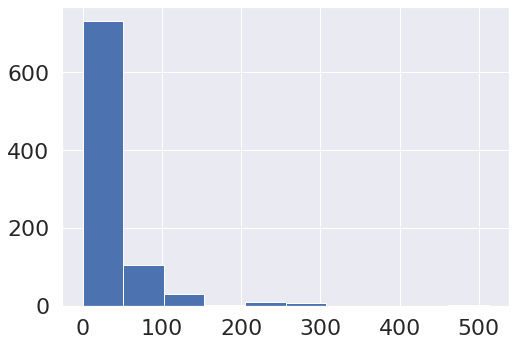

In [0]:
# 가장 기울어진, Fare 컬럼 시각화
plt.hist(psample_df["Fare"])

In [0]:
psample_df[["Fare"]].describe()

,Fare
count,891.000000
mean,32.204208
std,49.693429
min,0.000000
25%,7.910400
50%,14.454200
75%,31.000000
max,512.329200


In [0]:
psample_df[["Fare"]].median()

Out[23]: Fare    14.4542
dtype: float64

In [0]:
# Fare 컬럼 값들이 위와 같이 매우 비대칭이므로
## 모델 학습 시, outlier에 대해 민감하게 반응할 수 있다.
### outlier의 영향을 줄이기 위해 log 값으로 변환-대입

from pyspark.sql.functions import log1p

# log1p(x) : log(1+x) 연산, x값이 0일 경우에 대비
df_train=df_train.withColumn("Fare", log1p("Fare"))

In [0]:
df_train[["Fare"]].show()

+------------------+
|              Fare|
+------------------+
|2.1102132003465894|
|   4.2805931204649|
| 2.188856327665703|
|3.9908341858524357|
|2.2027647577118348|
| 2.246892662898172|
| 3.967694202798607|
| 3.094445746490024|
|2.4959537387180646|
| 3.436268471383741|
|2.8735646395797834|
|3.3160025355989236|
|2.2027647577118348|
|3.4742929367327062|
| 2.180891922715322|
| 2.833213344056216|
| 3.405355391810819|
| 2.639057329615259|
|2.9444389791664403|
|2.1071782966514356|
+------------------+
only showing top 20 rows



In [0]:
# 기울임 다시 조회
psample_df=df_train.toPandas()

psample_df.skew()

Out[26]: PassengerId    0.000000
Pclass        -0.630548
Age            0.389108
SibSp          3.695352
Parch          2.749117
Fare           0.394928
Survived       0.478523
dtype: float64

Out[27]: (array([ 15.,   0.,   2., 350., 167., 182.,  85.,  59.,  28.,   3.]),
 array([0.        , 0.62409174, 1.24818347, 1.87227521, 2.49636694,
        3.12045868, 3.74455041, 4.36864215, 4.99273388, 5.61682562,
        6.24091735]),
 <BarContainer object of 10 artists>)

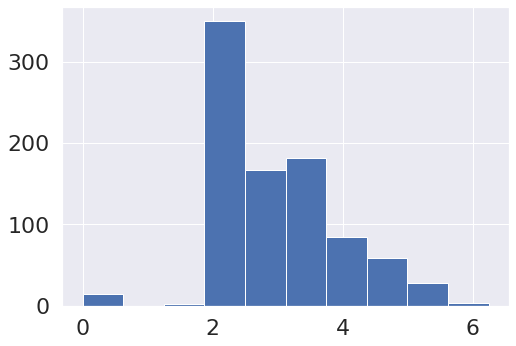

In [0]:
plt.hist(psample_df["Fare"])


## 새 컬럼 추가

### 가족 수 관련 컬럼, `FamilySize` 컬럼, 추가 - `Parch` 와 `SibSp` 컬럼 참고

In [0]:
# SibSp : 배우자 수 , Parch : 동승한 부모 자식 수
## SibSp+Parch+1 : SibSp=0, Parch=0 일 경우, 본인 1명은 있어야하므로 +1
df_train = df_train.withColumn("FamilySize", df_train["SibSp"]+df_train["Parch"]+1)

In [0]:
display(df_train[["FamilySize"]])

FamilySize
2
2
1
2
1
1
1
5
3
2



### 가족 수 와 생존 사이의 관계 파악

In [0]:
df_train.crosstab("FamilySize","Survived").show()

+-------------------+---+---+
|FamilySize_Survived|  0|  1|
+-------------------+---+---+
|                  5| 12|  3|
|                  1|374|163|
|                  6| 19|  3|
|                  2| 72| 89|
|                  7|  8|  4|
|                  3| 43| 59|
|                 11|  7|  0|
|                  8|  6|  0|
|                  4|  8| 21|
+-------------------+---+---+



In [0]:
# 새 컬럼이 추가되어 view 를 다시 생성
df_train.createOrReplaceTempView('titanic_view')

In [0]:
%sql

select FamilySize, Survived, count(*)
from titanic_view
group by FamilySize, Survived
order by FamilySize, Survived desc

FamilySize,Survived,count(1)
1,1,163
1,0,374
2,1,89
2,0,72
3,1,59
3,0,43
4,1,21
4,0,8
5,1,3
5,0,12



### "Sir" 컬럼 추가 - `Name` 컬럼 참고

- 이전 EDA 과정에서 `Age`와 `Sex` 가 생존과 밀접한 관계가 있음을 알 수 있다.
  - `Age`의 경우, 유일하게 대략 10세 미만의 생존자 수가 사망자 수보다 많았음.  

- 따라서, 성별과 나이의 의미를 포함한 `Sir` 컬럼을 만들어 관계 분석

> Miss : 미혼 여자, Mrs : 기혼 여자, Mr : 성인 남자, Master : 귀족집안의 미성년 남자, 도련님 의미

In [0]:
%sql

select Name from titanic_view

Name
"Braund, Mr. Owen Harris"
"Cumings, Mrs. John Bradley (Florence Briggs Thayer)"
"Heikkinen, Miss. Laina"
"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
"Allen, Mr. William Henry"
"Moran, Mr. James"
"McCarthy, Mr. Timothy J"
"Palsson, Master. Gosta Leonard"
"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"
"Nasser, Mrs. Nicholas (Adele Achem)"


In [0]:
import re

# 다음 단어 중 하나를 포함한 문자열을 찾기 위한 객체 생성
p = re.compile("Mrs|Mr|Miss|Master|Don|Dr|Ms|Major|Mlle|Mme|Countess|Lady")

In [0]:
# 이름으로부터 Mr Mrs Miss 리턴 함수

def get_sir(name) :
    if p.search(name) != None:
        if p.search(name)[0] in ['Countess', 'Lady']:
            return "Mrs"
        elif p.search(name)[0] in ["Mme", "Ms", "Mlle"]:
            return "Miss"
        elif p.search(name)[0] in ["Don", "Dr", "Major"]:
            return "Mr"
        else:
            return p.search(name)[0]
    else:
        return "Other"


In [0]:
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

In [0]:
# udf(lambda 컬럼의 데이터 하나씩 저장할 변수: 함수명, 리턴받을 결과의 타입)
udf_get_sir = udf(lambda x:get_sir(x), StringType())

In [0]:
df_train = df_train.withColumn("Sir", udf_get_sir(df_train["Name"]))

df_train.show()

+-----------+------+--------------------+------+----+-----+-----+----------------+------------------+-----+--------+--------+----------+------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|              Fare|Cabin|Embarked|Survived|FamilySize|   Sir|
+-----------+------+--------------------+------+----+-----+-----+----------------+------------------+-----+--------+--------+----------+------+
|          1|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|2.1102132003465894| null|       S|       0|         2|    Mr|
|          2|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|   4.2805931204649|  C85|       C|       1|         2|   Mrs|
|          3|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282| 2.188856327665703| null|       S|       1|         1|  Miss|
|          4|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|3.9908341858524357| C123|       S|       1|         2|

In [0]:
# Sir 컬럼과 생존 사이의 관계 분석
df_train.crosstab("Sir", "Survived").show()

+------------+---+---+
|Sir_Survived|  0|  1|
+------------+---+---+
|       Other|  9|  1|
|      Master| 17| 23|
|          Mr|442| 88|
|         Mrs| 26|100|
|        Miss| 55|130|
+------------+---+---+



In [0]:
# 새 컬럼이 추가되어 view 를 다시 생성
df_train.createOrReplaceTempView('titanic_view')

In [0]:
%sql

select Sir, Survived, count(*)
from titanic_view
group by Sir, Survived
order by Sir asc, Survived desc

Sir,Survived,count(1)
Master,1,23
Master,0,17
Miss,1,130
Miss,0,55
Mr,1,88
Mr,0,442
Mrs,1,100
Mrs,0,26
Other,1,1
Other,0,9



---

In [0]:
%sql

select Pclass, FamilySize, count(*)
from titanic_view
where FamilySize =2 or FamilySize =3 or FamilySize =4
group by Pclass, FamilySize
order by Pclass asc, FamilySize asc

Pclass,FamilySize,count(1)
1,2,70
1,3,24
1,4,7
2,2,34
2,3,31
2,4,13
3,2,57
3,3,47
3,4,9


In [0]:
# 데이터 info를 위해 Pandas DataFrame 재생성
psample_df2 = df_train.toPandas()
psample_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    object 
 1   Pclass       891 non-null    int32  
 2   Name         891 non-null    object 
 3   Sex          891 non-null    object 
 4   Age          714 non-null    float64
 5   SibSp        891 non-null    int32  
 6   Parch        891 non-null    int32  
 7   Ticket       891 non-null    object 
 8   Fare         891 non-null    float64
 9   Cabin        204 non-null    object 
 10  Embarked     889 non-null    object 
 11  Survived     891 non-null    int32  
 12  FamilySize   891 non-null    int32  
 13  Sir          891 non-null    object 
dtypes: float64(2), int32(5), object(7)
memory usage: 80.2+ KB


In [0]:
# FamilySize가 2 중 각각의 Pclass 별 백분율

a = df_train[['Pclass']].filter(df_train['FamilySize']==2).filter(df_train["Pclass"]==1).count() / df_train[["Pclass"]].filter(df_train['FamilySize']==2).count()
b = df_train[['Pclass']].filter(df_train['FamilySize']==2).filter(df_train["Pclass"]==2).count() / df_train[["Pclass"]].filter(df_train['FamilySize']==2).count()
c = df_train[['Pclass']].filter(df_train['FamilySize']==2).filter(df_train["Pclass"]==3).count() / df_train[["Pclass"]].filter(df_train['FamilySize']==2).count()

print(round(a,4)*100, round(b,4)*100, round(c,4)*100)

43.480000000000004 21.12 35.4



---


## 결측치 처리
### 나이 결측치 처리

In [0]:
df_train.groupBy('Sir').mean().show()

+------+------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+
|   Sir|       avg(Pclass)|         avg(Age)|         avg(SibSp)|        avg(Parch)|         avg(Fare)|     avg(Survived)|   avg(FamilySize)|
+------+------------------+-----------------+-------------------+------------------+------------------+------------------+------------------+
|  Miss| 2.281081081081081|            21.86| 0.7027027027027027|0.5405405405405406|3.1923512431103003|0.7027027027027027|2.2432432432432434|
| Other|               1.6|             48.3|                0.2|               0.2|2.8486349174633236|               0.1|               1.4|
|Master|             2.625|4.574166666666667|                2.3|             1.375|  3.38136084875905|             0.575|             4.675|
|    Mr|2.3849056603773584|32.65158924205379|0.29245283018867924|0.1509433962264151|2.7281409248276858|0.1660377358490566|1.4433962264150944|
|   Mr

In [0]:
df_train[["Sir","Age"]].show()

+------+----+
|   Sir| Age|
+------+----+
|    Mr|22.0|
|   Mrs|38.0|
|  Miss|26.0|
|   Mrs|35.0|
|    Mr|35.0|
|    Mr|null|
|    Mr|54.0|
|Master| 2.0|
|   Mrs|27.0|
|   Mrs|14.0|
|  Miss| 4.0|
|  Miss|58.0|
|    Mr|20.0|
|    Mr|39.0|
|  Miss|14.0|
|   Mrs|55.0|
|Master| 2.0|
|    Mr|null|
|   Mrs|31.0|
|   Mrs|null|
+------+----+
only showing top 20 rows



In [0]:
sir_df = df_train[["Sir","Age"]].groupby("Sir").mean()

In [0]:
sir_df = sir_df.withColumnRenamed("avg(Age)","avg_age")

In [0]:
sir_df = sir_df.toPandas()

#  index가 행번호로 되어있음.

In [0]:
sir_df

,Sir,avg_age
0,Miss,21.860000
1,Other,48.300000
2,Master,4.574167
3,Mr,32.651589
4,Mrs,36.000000


In [0]:
sir_df.set_index("Sir",inplace=True)

In [0]:
sir_df.to_dict()

Out[60]: {'avg_age': {'Miss': 21.86,
  'Other': 48.3,
  'Master': 4.574166666666667,
  'Mr': 32.65158924205379,
  'Mrs': 36.0}}

In [0]:
sir_df.to_dict()["avg_age"]

Out[61]: {'Miss': 21.86,
 'Other': 48.3,
 'Master': 4.574166666666667,
 'Mr': 32.65158924205379,
 'Mrs': 36.0}

In [0]:
sir_df_dic = sir_df.to_dict()["avg_age"]

In [0]:
sir_df_dic

Out[67]: {'Miss': 21.86,
 'Other': 48.3,
 'Master': 4.574166666666667,
 'Mr': 32.65158924205379,
 'Mrs': 36.0}

In [0]:
# Age 컬럼 값이 결측치일 때 Sir 컬럼의 Mr Mrs Miss 의 평균 리턴
import math

def get_age(age, sir):
    # 함수 외부에서 선언한 변수 sir_df_dic 사용
    global sir_df_dic

    # 결측치인 나이 컬럼 값이 있는 확인
    # 결측치인 경우 Sir 값에 따라 평균 나이로 대체 
    if (age is None) or (len(str(age))==0) or math.isnan(age):
        return sir_df_dic[sir]
    else:
        return age

In [0]:
# udf 와 get_age() 함수를 통해
## Spark DataFrame 의 컬럼 값들을 수정해서 리턴
from pyspark.sql.types import DoubleType

udf_get_age = udf(lambda age, sir:get_age(age,sir), DoubleType())

In [0]:
df_train = df_train.withColumn("Age", udf_get_age(df_train["Age"], df_train["Sir"]))

In [0]:
display(df_train)

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,FamilySize,Sir
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,2.1102132003465894,null,S,0,2,Mr
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,4.2805931204649,C85,C,1,2,Mrs
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.188856327665703,null,S,1,1,Miss
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.9908341858524357,C123,S,1,2,Mrs
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.2027647577118348,null,S,0,1,Mr
6,3,"Moran, Mr. James",male,32.65158924205379,0,0,330877,2.246892662898172,null,Q,0,1,Mr
7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,3.967694202798607,E46,S,0,1,Mr
8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,3.094445746490024,null,S,0,5,Master
9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,2.4959537387180646,null,S,1,3,Mrs
10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,3.436268471383741,null,C,1,2,Mrs



### `Embarked` 컬럼 결측치 처리

- 최빈값을 이용해 결측치 값 대체

In [0]:
%sql

select Embarked, count(*) from titanic_view group by Embarked

Embarked,count(1)
Q,77
null,2
C,168
S,644


In [0]:
# 결측값 S로 대체
df_train = df_train.fillna({'Embarked':'S'})

Out[74]: <AxesSubplot:>

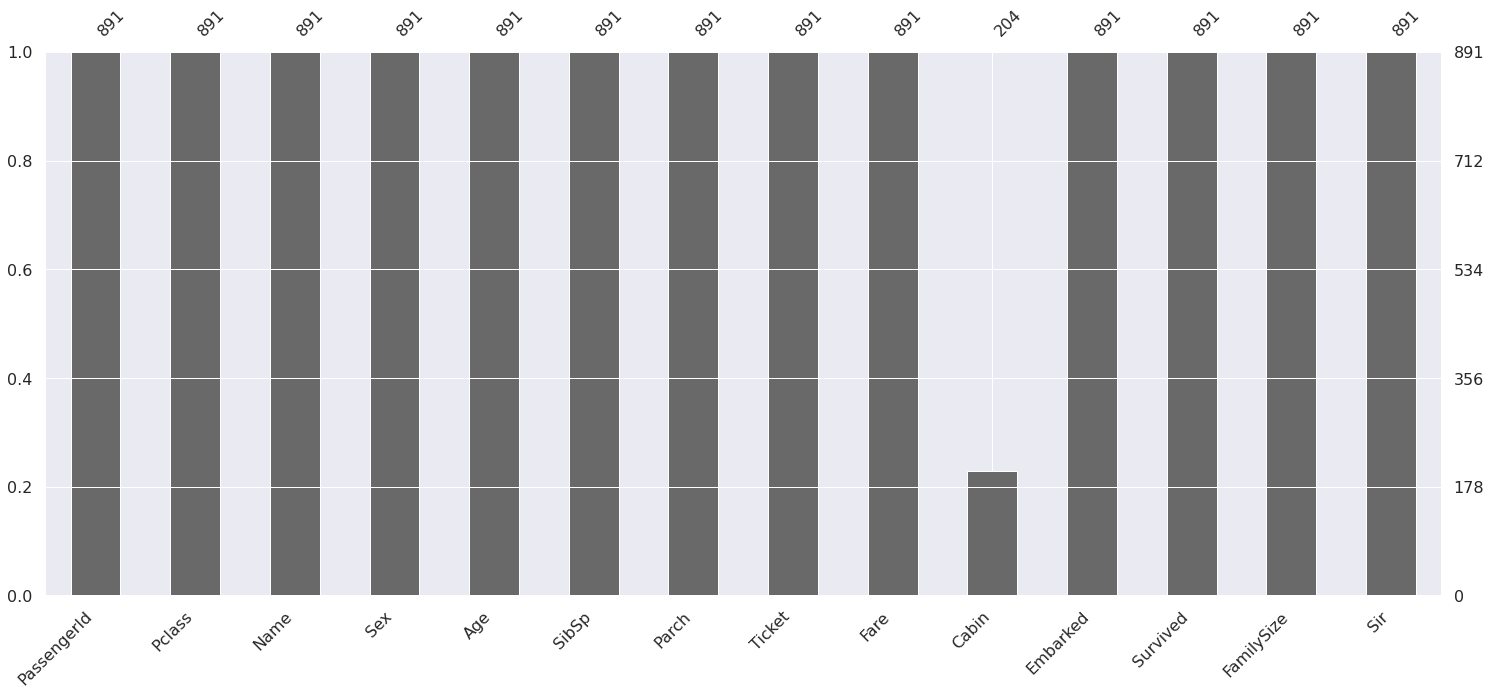

In [0]:
import missingno as msno

# msno.bar() : 각 컬럼의 null 이 아닌 데이터의 비율을 그래프로 그려주는 모듈
msno.bar(df=df_train.toPandas())


- 위의 결과로부터 `Cabin` 컬럼값을 제외한 나머지 컬럼들의 결측치는 조회되지 않는다
- `Cabin` 의 경우, 결측치가 너무 많고 데이터가 너무 다양해 학습 결과에 영향 X, 삭제할 예정


## 범주형(Categorical) 데이터 처리

- 해당 범주형 데이터들은 숫자값으로 변환할 것


### 나이, `Age` 컬럼 처리

In [0]:
# 나
# 이의 10의 자리 수만  가져와
# 해당 값들을 나이 컬럼의 대표값으로 대체

def get_age_category(age):

    return age //10

In [0]:
udf_get_age_category = udf(lambda x:get_age_category(x), DoubleType())

df_train = df_train.withColumn("Age_Category", udf_get_age_category(df_train["Age"]))

df_train.show()

+-----------+------+--------------------+------+-----------------+-----+-----+----------------+------------------+-----+--------+--------+----------+------+------------+
|PassengerId|Pclass|                Name|   Sex|              Age|SibSp|Parch|          Ticket|              Fare|Cabin|Embarked|Survived|FamilySize|   Sir|Age_Category|
+-----------+------+--------------------+------+-----------------+-----+-----+----------------+------------------+-----+--------+--------+----------+------+------------+
|          1|     3|Braund, Mr. Owen ...|  male|             22.0|    1|    0|       A/5 21171|2.1102132003465894| null|       S|       0|         2|    Mr|         2.0|
|          2|     1|Cumings, Mrs. Joh...|female|             38.0|    1|    0|        PC 17599|   4.2805931204649|  C85|       C|       1|         2|   Mrs|         3.0|
|          3|     3|Heikkinen, Miss. ...|female|             26.0|    0|    0|STON/O2. 3101282| 2.188856327665703| null|       S|       1|         1| 


- `Age` 값의 10의 자리수만 가져와 `Age_category` 컬럼을 추가함으로써
- group 별로 나누었고, 분류 학습 모델을 하는데 용이하게 하기 위함이었습니다.

> 그대로 continuous 값인 형태로 할 수도 있었음.


### `Sir` 컬럼 처리

- Mr, Mrs, Miss, Master, Other 총 5개로 이루어진 카테고리를
- 숫자형 데이터로 변환해 컴퓨터 학습이 가능하게 한다.

In [0]:
from pyspark.ml.feature import StringIndexer

In [0]:
# Sir 컬럼을 이용해 Sir_Category 컬럼 생성

string_indexer = StringIndexer(inputCols=["Sir"], outputCols=["Sir_Category"])

In [0]:
# Sir 컬럼 문자열 파악
sir_transformer = string_indexer.fit(df_train)

In [0]:
sir_transformer.labels

# Sir 컬럼 문자열 조회 및 리스트 리턴
## 문자열의 인덱스로 변환

Out[83]: ['Mr', 'Miss', 'Mrs', 'Master', 'Other']

In [0]:
sir_transformer.transform(df_train).show()

+-----------+------+--------------------+------+-----------------+-----+-----+----------------+------------------+-----+--------+--------+----------+------+------------+------------+
|PassengerId|Pclass|                Name|   Sex|              Age|SibSp|Parch|          Ticket|              Fare|Cabin|Embarked|Survived|FamilySize|   Sir|Age_Category|Sir_Category|
+-----------+------+--------------------+------+-----------------+-----+-----+----------------+------------------+-----+--------+--------+----------+------+------------+------------+
|          1|     3|Braund, Mr. Owen ...|  male|             22.0|    1|    0|       A/5 21171|2.1102132003465894| null|       S|       0|         2|    Mr|         2.0|         0.0|
|          2|     1|Cumings, Mrs. Joh...|female|             38.0|    1|    0|        PC 17599|   4.2805931204649|  C85|       C|       1|         2|   Mrs|         3.0|         2.0|
|          3|     3|Heikkinen, Miss. ...|female|             26.0|    0|    0|STON/O2

In [0]:
df_train = sir_transformer.transform(df_train)

# Mr -> 0, Miss -> 1, Mrs -> 2, Master -> 3, Other -> 4
## 각 컬럼값들의 빈도수순으로 index 값이 정해짐

In [0]:
display(df_train)

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,FamilySize,Sir,Age_Category,Sir_Category
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,2.1102132003465894,null,S,0,2,Mr,2.0,0.0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,4.2805931204649,C85,C,1,2,Mrs,3.0,2.0
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.188856327665703,null,S,1,1,Miss,2.0,1.0
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.9908341858524357,C123,S,1,2,Mrs,3.0,2.0
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.2027647577118348,null,S,0,1,Mr,3.0,0.0
6,3,"Moran, Mr. James",male,32.65158924205379,0,0,330877,2.246892662898172,null,Q,0,1,Mr,3.0,0.0
7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,3.967694202798607,E46,S,0,1,Mr,5.0,0.0
8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,3.094445746490024,null,S,0,5,Master,0.0,3.0
9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,2.4959537387180646,null,S,1,3,Mrs,2.0,2.0
10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,3.436268471383741,null,C,1,2,Mrs,1.0,2.0



## `Embarked` 컬럼 처리

- C, Q, S 의 값들을 수치형 데이터로 변환

In [0]:
string_indexer = StringIndexer(inputCols=["Embarked"], outputCols=["Embarked_Category"])

In [0]:
embarked_transformer = string_indexer.fit(df_train)

In [0]:
embarked_transformer.labels

Out[89]: ['S', 'C', 'Q']

In [0]:
df_train = embarked_transformer.transform(df_train)

In [0]:
display(df_train)

PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived,FamilySize,Sir,Age_Category,Sir_Category,Embarked_Category
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,2.1102132003465894,null,S,0,2,Mr,2.0,0.0,0.0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38.0,1,0,PC 17599,4.2805931204649,C85,C,1,2,Mrs,3.0,2.0,1.0
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,2.188856327665703,null,S,1,1,Miss,2.0,1.0,0.0
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,3.9908341858524357,C123,S,1,2,Mrs,3.0,2.0,0.0
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,2.2027647577118348,null,S,0,1,Mr,3.0,0.0,0.0
6,3,"Moran, Mr. James",male,32.65158924205379,0,0,330877,2.246892662898172,null,Q,0,1,Mr,3.0,0.0,2.0
7,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,3.967694202798607,E46,S,0,1,Mr,5.0,0.0,0.0
8,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,3.094445746490024,null,S,0,5,Master,0.0,3.0,0.0
9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,2.4959537387180646,null,S,1,3,Mrs,2.0,2.0,0.0
10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,3.436268471383741,null,C,1,2,Mrs,1.0,2.0,1.0



## `Sex`, 성별 컬럼 처리

In [0]:
string_indexer = StringIndexer(inputCols=["Sex"], outputCols=["Sex_Category"])

In [0]:
sex_transformer = string_indexer.fit(df_train)

In [0]:
sex_transformer.labels

Out[98]: ['male', 'female']

In [0]:
df_train = sex_transformer.transform(df_train)

In [0]:
df_train.show()

+-----------+------+--------------------+------+-----------------+-----+-----+----------------+------------------+-----+--------+--------+----------+------+------------+------------+-----------------+------------+
|PassengerId|Pclass|                Name|   Sex|              Age|SibSp|Parch|          Ticket|              Fare|Cabin|Embarked|Survived|FamilySize|   Sir|Age_Category|Sir_Category|Embarked_Category|Sex_Category|
+-----------+------+--------------------+------+-----------------+-----+-----+----------------+------------------+-----+--------+--------+----------+------+------------+------------+-----------------+------------+
|          1|     3|Braund, Mr. Owen ...|  male|             22.0|    1|    0|       A/5 21171|2.1102132003465894| null|       S|       0|         2|    Mr|         2.0|         0.0|              0.0|         0.0|
|          2|     1|Cumings, Mrs. Joh...|female|             38.0|    1|    0|        PC 17599|   4.2805931204649|  C85|       C|       1|      